In [1]:
# from utils import solve_graph_weights, log2_comb, dig_sparse_level, MyNeighbour,comp_quant_encoding
from scipy.stats import norm
from scipy.special import binom
import numpy as np
import matplotlib.pyplot as plt
import networkx as net
import pandas as pd
import pickle
import itertools
from functools import partial
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit
import cvxpy as cvx
import plotly.express as pltly

In [2]:
np.set_printoptions(suppress = True)

parameters for $\mu-L$ convergence
* $\mu = \lambda$       regularization parameter

In [4]:
# train_images=train_images.reshape((60000,784),order='C')
# SampleCov=[(train_images[sample_indices[i]].T @ train_images[sample_indices[i]]) / len(sample_indices[i]) for i in range(K)]
# lambdaSampleCov=[np.linalg.eigvalsh(SampleCov[i]).reshape((784,1)) for i in range(K)]
# E = 1./2*(np.eye(K) - np.ones((K,1)) @ np.ones((1,K)) / K)
# lambdaE=np.linalg.eigvalsh(E).reshape((K,1))
# lambda_base = [max(.5*lambdaSampleCov[i]).squeeze() for i in range(K)]
lamda = .1
# L = max(lambda_base) + lamda
L = .3298 + lamda
mu = lamda
kappa = L / mu
gb = .1 # as the norm bound G for gradient
K = 20
d = 7850
N = 1e4
M= 2
m = N/(2*M) # N/(2*M), where 2M is the total number of scheduling slots for M-round 'star-like' commun.
rho = 1e6 #average SNR ~40dB

seeds = iter(range(1000))
alg_connect = 0
while alg_connect < 1e-4:
    G = net.erdos_renyi_graph(K, .2, seed = next(seeds))
    LP = np.array(net.laplacian_matrix(G).todense())
    D, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
    alg_connect = D[1] 
alpha = 2 / (D[K-1] + D[1])
W = np.eye(K) - alpha * LP
# pos = net.spring_layout(G)
# net.draw(G, pos, with_labels = True, node_size = 500, edge_size = 300, font_size = 16)

beta = np.linalg.norm(np.eye(K) - W, ord=2)
delta = 1 - np.linalg.norm(np.ones((K,1)) @ np.ones((1,K)) / K - W, ord=2)
omega = m/d
zeta_ini = delta * omega / (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega)
# b = 6/mu
# a = 24 * kappa
# c = 100
if (delta**2/4 + 2/omega * beta**2)*zeta_ini - delta <=0:
    a_prime = 40072.
else:
    a_prime = .99 * delta / ((delta**2/4 + 2/omega * beta**2)*zeta_ini - delta)
        
# eta = lambda t: b/(t+a)
zeta = lambda t: zeta_ini /(t/a_prime+1)
p = lambda t: -(delta**2 * zeta_ini**2/4 + 2*beta**2 * zeta_ini**2/omega)/((t/a_prime+1)**2) + delta*zeta_ini/(t/a_prime+1)
# eta = lambda t: c*p(t)**(1.4)
c = .999 * (delta * zeta_ini - (delta**2/4 + 2/omega * beta**2) * zeta_ini**2 / (1/a_prime + 1))
D = 13 * np.sqrt(2) * gb / (mu * c * a_prime)
eta = lambda t: D / (2*np.sqrt(2) * gb) * c / (t/a_prime+1)

# a1, a3 = lambda t: 2/p(t), lambda t: 2/p(t)
a2 = lambda t: delta*zeta(t) / 2
a4 = omega/2

In [5]:
# Set distances among any pair of nodes
d_min = 50
d_max = 200
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
# D = np.ones((K, K))
D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
for i in range(K):
    if i:
        D[i,i] = D[i,i-1]
    else:
        D[i,i] = D[i,i+1]
        
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
PL = A0 * ((D / d0) ** (-gamma))
# Generate per-iteration channels following Rayleigh fading
CH_gen = iter( np.random.randn(len(G.edges()),)/np.sqrt(2) + 1j * np.random.randn(len(G.edges()),)/np.sqrt(2) )
CH = np.ones((K, K), dtype=complex)  # Channel coefficients
for i in range(K):
    for j in G[i]:
        if j < i:
            CH[i, j] = next(CH_gen)
for i in range(K):
    for j in G[i]:
        if j > i:
            CH[i, j] = np.conjugate(CH[j, i])
CG = PL * (np.abs(CH)) ** 2 

In [105]:
np.mean(PL)

5.218221759312199e-10

In [4]:
e_cons_array = []
e_comp_array = []
e_sum_array = []
t_array = np.arange(1e4)
e_cons_pre = 0
e_comp_pre = 0
e_sum_pre = e_cons_pre + e_comp_pre
e_cons_array.append(e_cons_pre)
e_comp_array.append(e_comp_pre)
e_sum_array.append(e_sum_pre)
for t in t_array:
    e_cons =  (1+a2(t))*(1-delta*zeta(t))**2 * e_cons_pre + (1+1/a2(t)) * beta**2 * zeta(t)**2 * e_comp_pre +\
    m**2/d * M**2 * K * (zeta(t)**2) *t /rho
    e_comp = (1-omega)*(1+1/a4)*beta**2 * zeta(t)**2 * e_cons_pre + (1-omega)*(1+a4)*(1+beta*zeta(t))**2 * e_comp_pre +\
    (1-omega) * m**2/d * M**2 * K * (zeta(t)**2) *t /rho
    e_sum = (1-p(t) / 2) * e_sum_pre + \
    4/p(t) * K * (eta(t)**2) * gb**2 + (2-omega) * m**2/d * M**2 * K * (zeta(t)**2) *t /rho
#     e_sum = (1-p(0) / 2) * e_sum_pre + \
#     ((1-omega) * (1+a3(0)) + (1+a1(0))) * (K*d*zeta(t)**2*t/rho + K*eta(t)**2*gb**2)
    e_cons_array.append(e_cons)
    e_comp_array.append(e_comp)
    e_sum_array.append(e_sum)
    e_cons_pre = e_cons
    e_comp_pre = e_comp
    e_sum_pre = e_sum

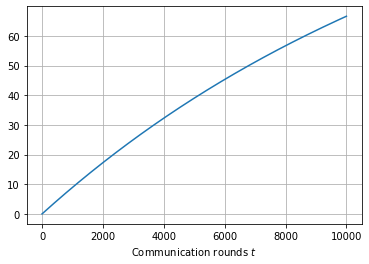

In [23]:
_, = plt.plot(e_sum_array)
plt.xlabel(r'Communication rounds $t$')
# plt.ylabel(r'Expected compression error $\mathbb{E}_{\mathrm{comp}_{B_i}}[\mathrm{comp}_{B_i}(\theta_i)-\theta_i]$')
# plt.xlim([8, 1])
plt.grid()
# _, = plt.plot((8 * gb **2 + 2/delta * ((2-omega) * omega**2 * d * M**2 * zeta_ini * a_prime / rho)) * K * np.ones(t_array.shape))

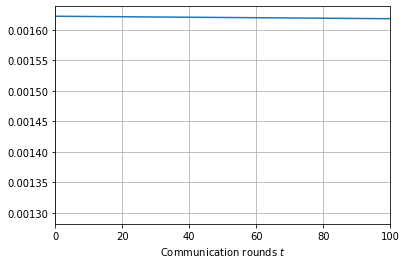

In [24]:
_, = plt.plot(list(map(eta,t_array)))
plt.xlabel(r'Communication rounds $t$')
# plt.ylabel(r'Expected compression error $\mathbb{E}_{\mathrm{comp}_{B_i}}[\mathrm{comp}_{B_i}(\theta_i)-\theta_i]$')
plt.xlim([0, 100])
plt.grid()

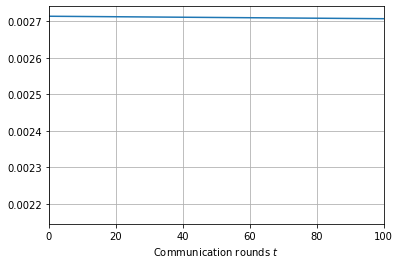

In [25]:
_, = plt.plot(list(map(zeta,t_array)))
plt.xlabel(r'Communication rounds $t$')
# plt.ylabel(r'Expected compression error $\mathbb{E}_{\mathrm{comp}_{B_i}}[\mathrm{comp}_{B_i}(\theta_i)-\theta_i]$')
plt.xlim([0, 100])
plt.grid()

In [26]:
(delta**2/4 + 2/omega * beta**2)*zeta_ini - delta

-0.08369152005610953

In [16]:
D = 13 * np.sqrt(2) * gb / (mu * c * a_prime)
C = D**2 + 2/delta * ((2-omega) * omega**2 * d * M**2 * zeta_ini * a_prime / rho)

In [17]:
D

2.0216430720682856

In [18]:
C

12.26112213252507

In [14]:
a1 = (13 * np.sqrt(2) * gb / (mu * c)) ** 2
a2 = 1/delta * ((2-omega) * omega**2 * d * M**2 * zeta_ini / rho)
a_prime=(a1 / a2) ** (1/3)

In [15]:
a_prime

40072.76562242624

Theorem 1 (modification of Theorem 19 [A.Koloskova *et al.* 19])

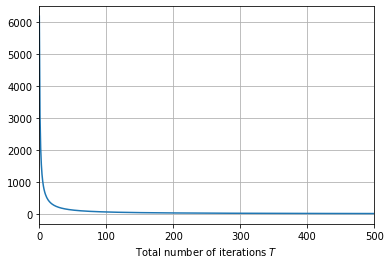

In [33]:
a0 = 10
sT = lambda T: np.sum((a_prime + np.arange(T))**2, axis = 0)
ub = lambda T: mu/6.5 * (a_prime**3 - 3.25 * a_prime**2) * a0 / sT(T) + 3.25 * T * (T+2 * a_prime -1) * (1/ K + 2 * L**2 *C) / (mu * sT(T))  + (L + mu) * C
# fig=pltly.line(x=t_array[1:], y=list(map(ub, t_array[1:])))
# fig.show()
_, = plt.plot(list(map(ub,t_array[1:])))
plt.xlabel(r'Total number of iterations $T$')
# plt.ylabel(r'Expected compression error $\mathbb{E}_{\mathrm{comp}_{B_i}}[\mathrm{comp}_{B_i}(\theta_i)-\theta_i]$')
plt.xlim([0, 500])
plt.grid()

In [9]:
losseses = pickle.load( open('../repo_jv/data/losseses_local_SGD_eta_0.10.pkl', 'rb') )
losseses = np.array(losseses)
K = losseses.shape[1]
df1 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )
losseses = pickle.load( open('../repo_jv/data/losseses_local_SGD_eta_5.00.pkl', 'rb') )
losseses = np.array(losseses)
df2 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

In [10]:
losseses.shape

(1, 4000, 20)

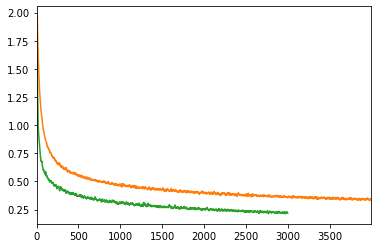

In [11]:
df1.rolling(window = 10).mean().mean(axis = 1).plot(color = 'tab:green')
df2.rolling(window = 10).mean().mean(axis = 1).plot(color = 'tab:orange')

In [16]:
np.mean(losseses, axis = 1)[2999]

0.21719281896948814

In [22]:
10 ** (2.3) * 1e-3

0.1995262314968879

In [23]:
.2/1e4

2e-05

In [46]:
W[1,:3]

array([0.1788335 , 0.10583248, 0.1788335 ])

In [48]:
N0

1.2589254117941713e-20

Generate a partial Hadamard matrix $\boldsymbol{H} \in \{\pm 1\}^{m\times d}$